### **Dopasowanie modelu do danych** metodą najmniejszych kwadratów (ang. *least-squares method*)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Zbiór danych** (ang. *dataset*) został opracowany na podstawie: <br>
[Eurostat](https://ec.europa.eu/eurostat/data/database), [World Happiness Report](https://worldhappiness.report/) <br>
Dla każdego państwa w Europie zestawiamy dwa rodzaje pomiarów/cech (ang. *features*): PKB na osobę i poczucie szczęścia obywatela.

In [61]:
import urllib.request
import os

plik = 'GDP_happiness.csv'
URL = "https://byes.pl/wp-content/uploads/datasets/" + plik
if not os.path.isfile(plik):
    print('Pobieram plik z ', URL)
    urllib.request.urlretrieve(URL, plik)
    print('Pobrano plik')
else:
    print(f'Plik {plik} już jest na dysku')

dane = pd.read_csv(plik, index_col=[0])

dane = dane.rename(columns={'GDP per capita' : 'GDP per capital'})

dane.index.name = 'Country'

display(dane)

Plik GDP_happiness.csv już jest na dysku


,GDP per capital,happiness
Country,,
Belgium,133.0,6.864
Bulgaria,28.2,5.102
Czech Republic,67.4,6.911
Denmark,172.5,7.646
Germany,133.2,7.076
Estonia,68.1,6.022
Ireland,231.9,7.094
Greece,54.9,5.515
Spain,84.8,6.401


**Oczyszczanie danych** <br>
Dane dotyczące poczucia szczęścia pobierałem automatem z pliku i pdf i akurat Łotwa została niepoprawnie odczytana. Brakujące dane zostaną uzupełnione średnią z pozostałych dostępnych pomiarów. <br>

In [62]:
dane = dane.fillna(dane.mean(axis=0))
dane.tail()

,GDP per capital,happiness
Country,,
Montenegro,25.500000,5.546
Albania,15.300000,4.883
Serbia,21.200000,5.778
Turkey,26.400000,5.132
Latvia,104.476471,5.950


**Ćwiczenie 1**: Zastanów się w jaki inny sposób można leczyć objawowo zbiory zawierające brakujące wartości?

In [63]:
dane.iloc[[-1], [0]] = 40.3 # From wikipedia
dane.tail()

,GDP per capital,happiness
Country,,
Montenegro,25.5,5.546
Albania,15.3,4.883
Serbia,21.2,5.778
Turkey,26.4,5.132
Latvia,40.3,5.950


Ramka danych jest strukturą pośredniczącą między różnymi rodzajami źródeł danych, a metodami przetwarzania/analizy danych. <br>
Z ramki zostaną wybrane dwie serie, wartości których trafią do osobnych tabel: 

In [64]:
X = dane['GDP per capital'].values
Y = dane['happiness'].values

**Wizualizacja danych** <br>
Można to zrobić biblioteką ```matplotlib```, ale to już znasz. Warto poznać możliwości biblioteki ```seaborn```, która pozwala na szybkie generowanie wizualizacji o jakości nadającej się do publikacji (ang. *publication quality*).

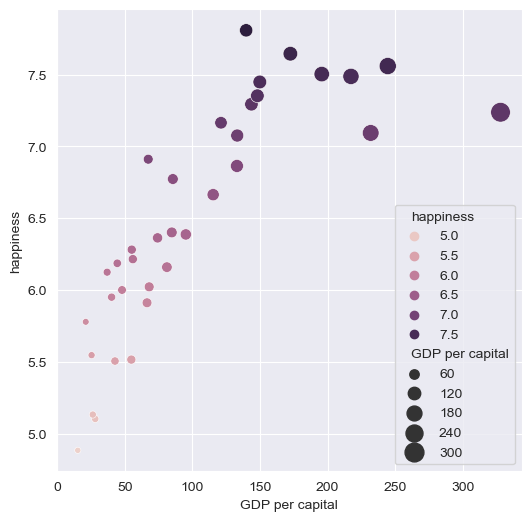

In [65]:
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(
    x='GDP per capital',
    y='happiness',
    data=dane,
    hue='happiness',
    size='GDP per capital',
    sizes=(20, 200),
    legend='brief',
)
plt.show()

**Ćwiczenie 2**: Jak w świetle przedstawionych danych oceniasz mądrość ludową *pieniądze szczęścia nie dają*?

In [66]:
# Dają szczęście

**Ćwiczenie 3**: Zwizualizuj przy użyciu biblioteki seaborn dane dotyczące szczęścia w poszczególnych krajach (barplot). Wyniki przedstaw w porządku malejącym.

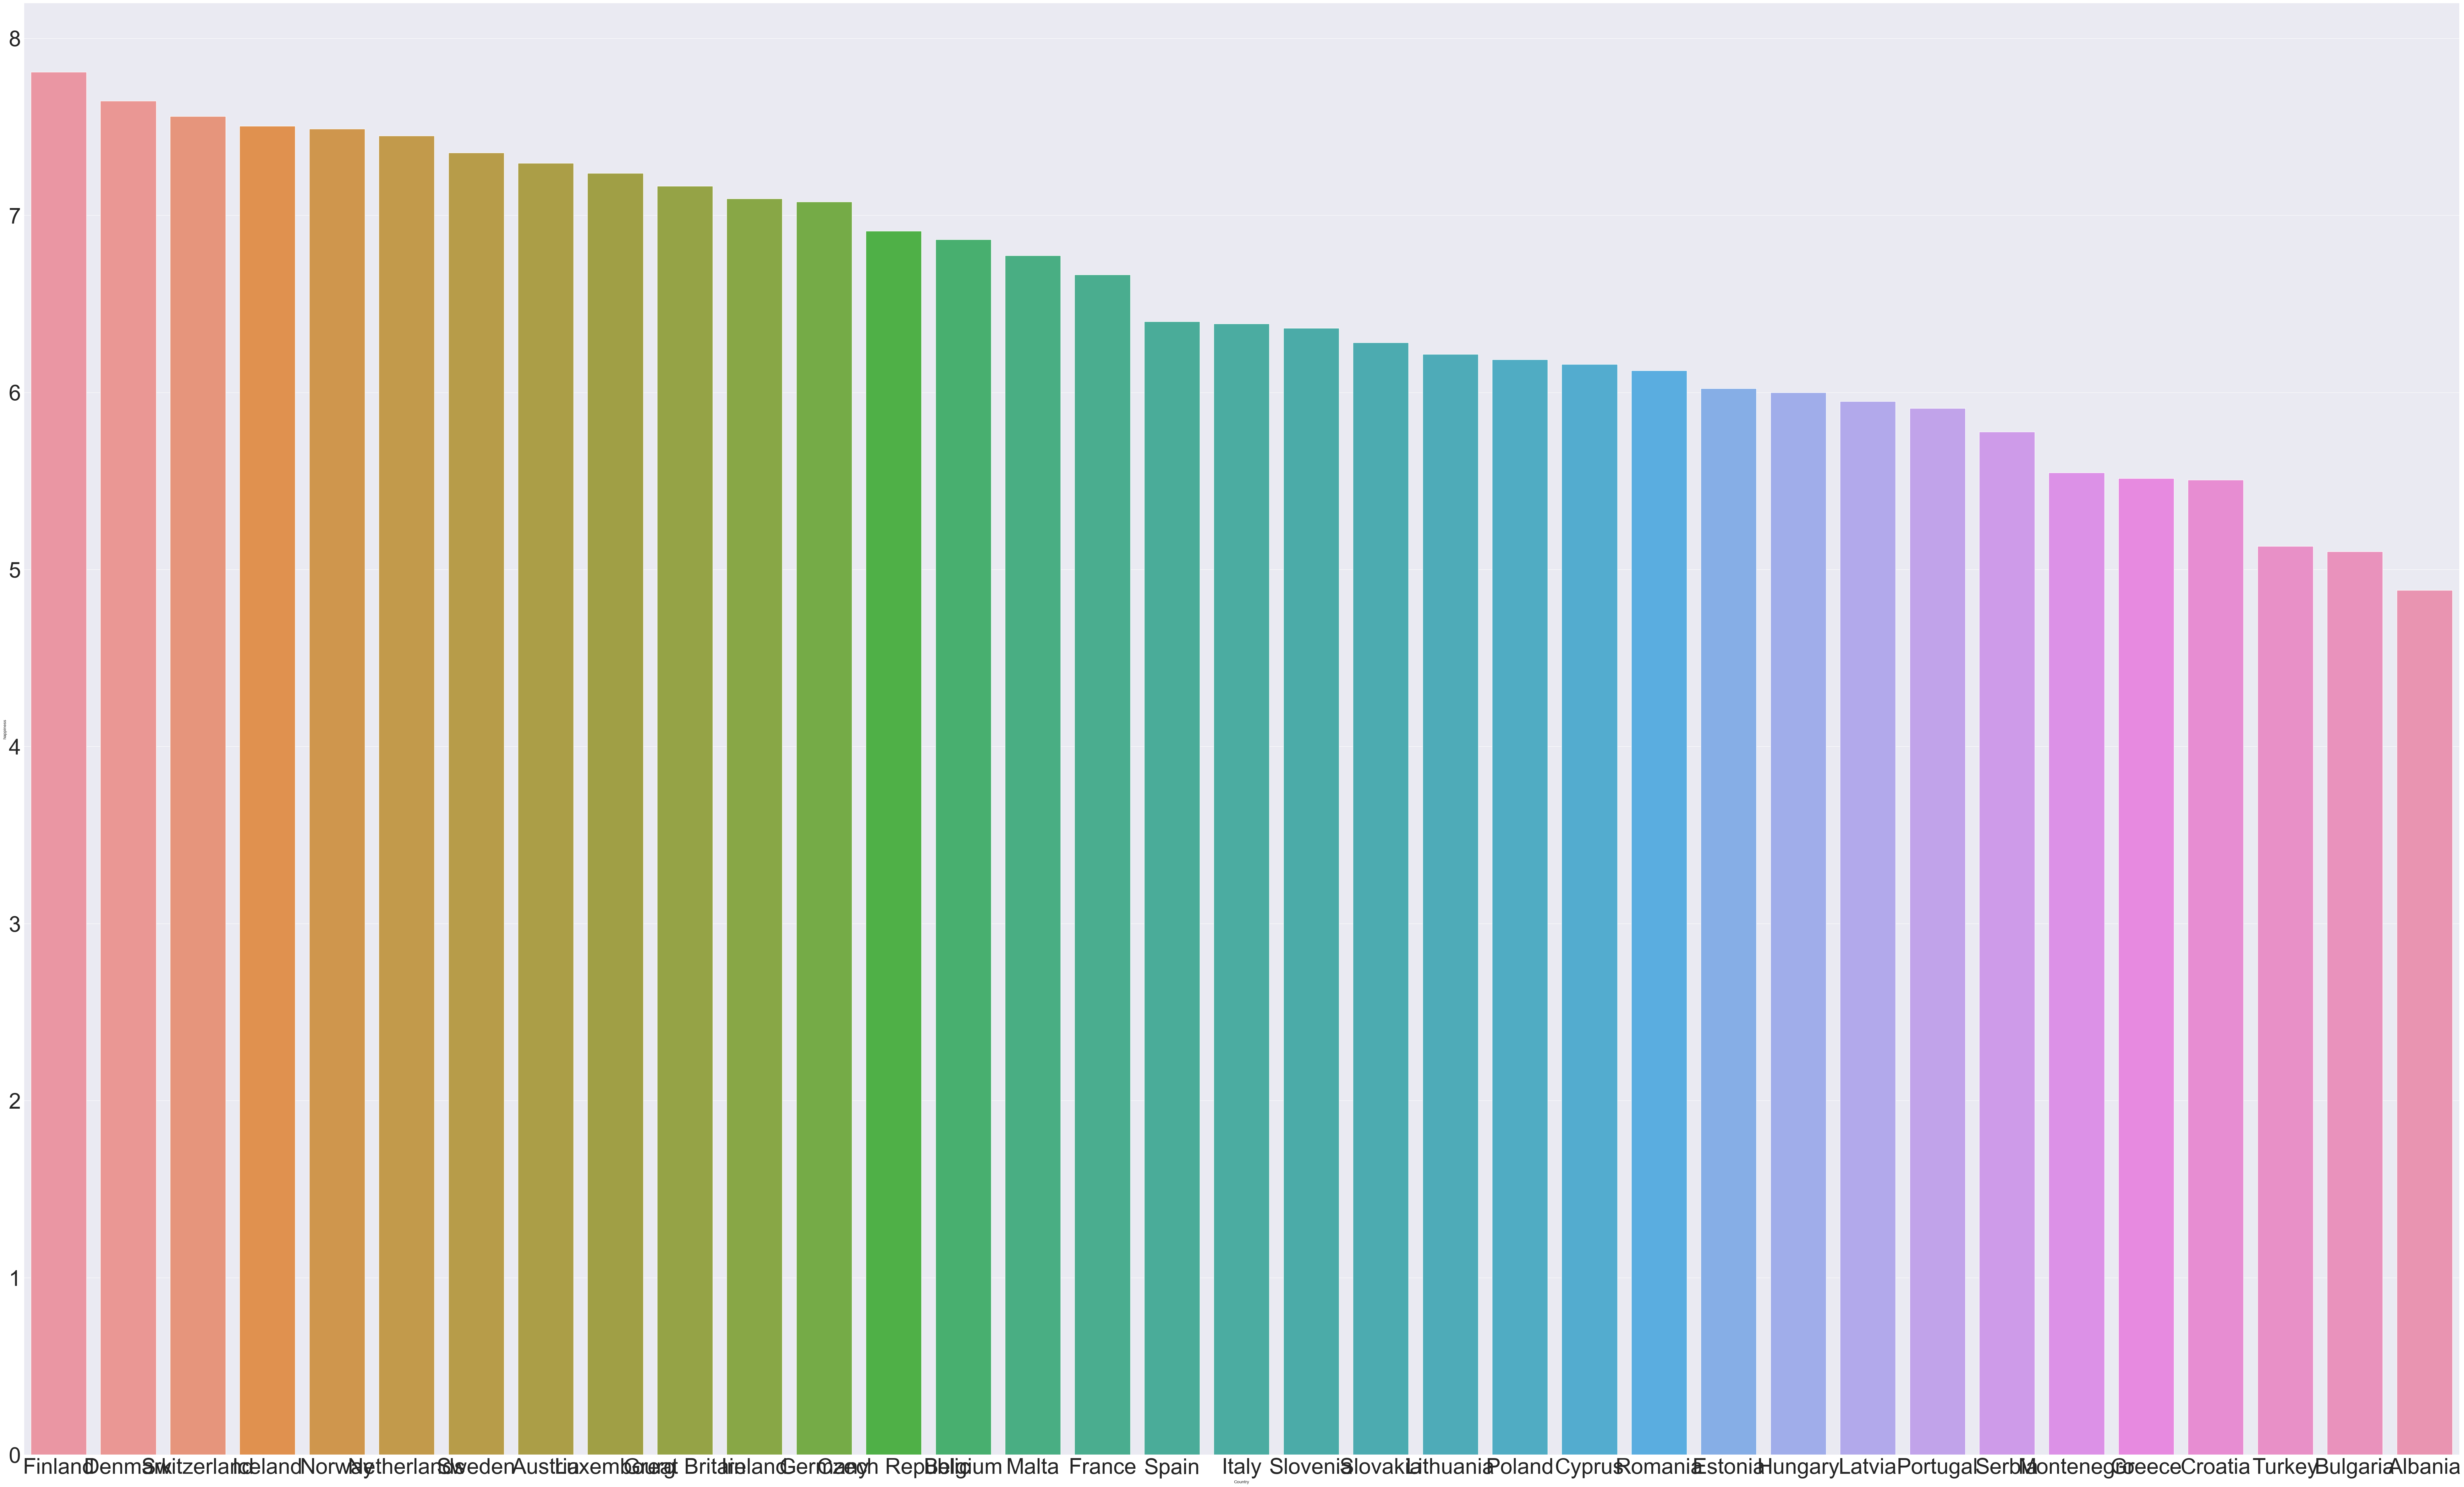

In [110]:
dane = dane.sort_values(by='happiness', ascending=False)
# Plot the barplot
plt.figure(figsize=(100,60))
sns.barplot(
    x=dane.index,
    y=dane.happiness,
    data=dane
)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.show()

**Dopasowanie do danych $\{(x_i,y_i)\}_{i=1}^N$ modelu** liniowego: $$\overline{y} = ax+b,$$
gdzie: <br>
$x$ - PKB na osobę (ang. *GDP per capita*), <br>
$y$ - poczucie szczęścia (ang. *hapiness*), <br>
$\overline{y}$ - przewidywana/wyliczona przez model wartość $y$ dla podanego $x$,<br>
$a, b$ - parametry modelu. <br><br>
Dane pomiarowe zmiennej wyjściowej można zebrać do macierzy:<br>
$Y = \begin{bmatrix} y_1 & y_2 & \cdots & y_N \end{bmatrix}$, <br>
a tak zwane ,,predykcje'' (przybliżenia) modelu do macierzy:<br> 
$\overline{Y} = \begin{bmatrix} \overline{y}_1 & \overline{y}_2 & \cdots & \overline{y}_N \end{bmatrix}$. <br>


**Ćwiczenie 4**: Spróbuj **metodą prób i błędów** dobrać wartości parametrów modelu $a$ i $b$ w taki sposób, aby model dobrze reprezentował dane, cokolwiek miałoby to znaczyć. Posłuż się poniższą komórką z kodem.

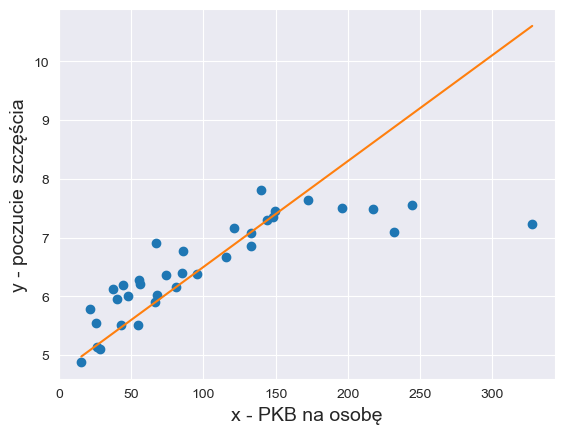

In [173]:
def model(parametry, x):
  a, b = parametry
  return a * x + b

# W tym miejscu wprowadzasz swoje oszacowania (ang. estimates) wartości parametrów modelu
a_est, b_est = 0.018, 4.7

# utwórz wartości x dla całego zakresu zmienności na osi x
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
# "odpytaj" model dla zakresu osi x objętego pomiarami
Y_pred = model(parametry=[a_est, b_est], x=X_test)

plt.scatter(X, Y)
plt.plot(X_test, Y_pred, color='tab:orange')
plt.xlabel('x - PKB na osobę', fontsize=14)
plt.ylabel('y - poczucie szczęścia', fontsize=14)
plt.show()

**Zastanów się**: co to właściwie znaczy, że jakieś zjawisko/proces ma charakter liniowy? Jak rozpoznać, że zjawisko/proces da się skutecznie opisywać modelem liniowym? <br>
Czy zależność między PKB na osobę a poczuciem szczęścia jest liniowa?

**Błąd średniokwadratowy** <br>
Niech błąd przybliżenia dla pojedynczej $i$-tej pary pomiarów wynosi:
$$e_i=y_i-\overline{y_i}.$$
Wybierz jeden z poniższych wzorów jako miarę błędu popełnianego przez model na danych $X,Y$:
\begin{equation}
Q(a,b) = \sum_{i=1}^Ne_i^2 \ ,
\tag{1}
\end{equation}

\begin{equation}
Q(a,b) = \frac{1}{N}\sum_{i=1}^Ne_i^2 \ ,
\tag{2}
\end{equation}

\begin{equation}
Q(a,b) = \frac{1}{N}\sqrt{\sum_{i=1}^Ne_i^2}\ .
\tag{3}
\end{equation}

**Ćwiczenie 5:** Zmodyfikuj komórkę z kodem tak, aby wizualizacja modelu na tle danych była uzupełniona wartością błędu przybliżenia. <br>
Dzięki temu metodę prób i błędów będzie można przeprowadzić bardziej precyzyjnie. <br>
**Zastanów się**: jakie ma znaczenie, które z kryteriów jakości $(1)$, $(2)$, $(3)$ zostało użyte.

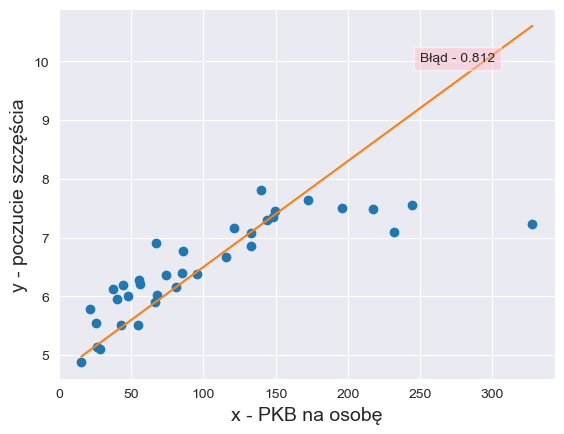

In [178]:
# 3
Y_test = np.linspace(start=Y.min(), stop=Y.max(), num=300)
es = Y_test - Y_pred
pow_es = np.power(es, 2)
sum_pow_es = np.sum(pow_es)
err = round(np.sqrt(sum_pow_es) / len(Y), 3)

plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color='tab:orange')
plt.xlabel('x - PKB na osobę', fontsize=14)
plt.ylabel('y - poczucie szczęścia', fontsize=14)
plt.text(250, 10, f'Błąd - {err}', bbox=dict(facecolor='pink', alpha=0.5))
plt.show()

**Ćwiczenie 6:** Poniżej znajduje się kopia ostatniej komórki. Jedyna różnica jest teraz taka, że trzeba **wyznaczyć parametry modelu sposobem analitycznym**.

Odpowiednie wzory powinny były pojawić się już na ćwiczeniach z tego kursu. Możesz również dodać wyznaczenie wartości kryterium jakości i porównać uzyskaną wartość z tą, którą udało Ci się osiągnąć metodą prób i błędów. <br>
**Zastanów się**: czy jest możliwe osiągnięcie wyniku lepszego niż zwraca metoda analityczna?

y = 0.00936020473448492 * x + 4.739788867562388


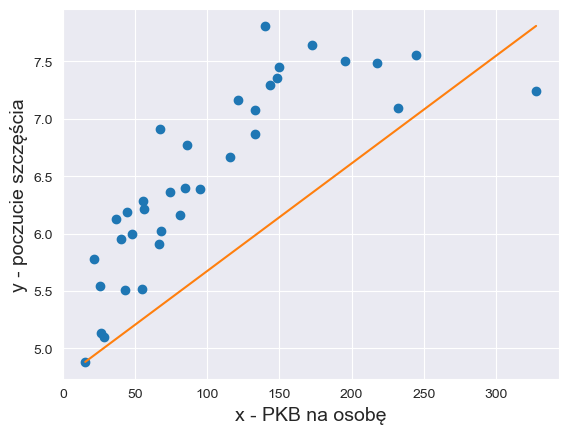

In [203]:
def model(parametry, x):
  a, b = parametry
  return a * x + b

#  w tym miejscu wprowadzasz wzory analityczne np. https://www.statystyczny.pl/regresja-liniowa/

x_mean = np.mean(X_test)
y_mean = np.mean(Y_test)

a_est = np.sum((X_test - x_mean) * (Y_test - x_mean)) / np.sum((X_test - x_mean) ** 2)
b_est = y_mean - a_est * x_mean

print(f"y = {a_est} * x + {b_est}")

# "odpytaj" model dla zakresu osi x objętego pomiarami
Y_pred = model(parametry=[a_est, b_est], x=X_test)

plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color='tab:orange')
plt.xlabel('x - PKB na osobę', fontsize=14)
plt.ylabel('y - poczucie szczęścia', fontsize=14)
plt.show()

**Ćwiczenie 7:** Zastosuj poznany na ćwiczeniach algorytm analityczny do estymacji parametrów modelu liniowego:
\begin{equation}
\widehat{\theta} = (XX^T)^{-1} XY^T, 
\tag{4}
\end{equation}
gdzie $\theta = \begin{bmatrix} a \\ b \end{bmatrix}$. Przemyśl konstrukcję macierzy $X$. Implementacja wzoru (4) powinna zająć jedną linijkę kodu.

In [355]:
def model(parametry, x):
  a, b = parametry
  return a * x + b

#  w tym miejscu wprowadzasz wzory analityczne


x_resh = X_test.reshape(-1, 1).T
y_resh = Y_test.reshape(-1, 1).T

out = np.linalg.inv(x_resh @ x_resh.T) @ (x_resh @ y_resh.T)

print(out)



def plot_fig(X: np.ndarray, Y: np.ndarray, coeff: np.ndarray):
  X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
  func_str = "y = "
  Y_pred = model(coeff, X_test)
  for i, c in enumerate(coeff.ravel()[::-1]):
      func_str += f"{round(c, 4)} * x ** {i} + "

  plt.scatter(X, Y, label='dane rzeczywiste')
  plt.plot(X_test, Y_pred, color='tab:orange', label='estymowany trend')
  plt.xlabel('x - PKB na osobę', fontsize=14)
  plt.ylabel('y - poczucie szczęścia', fontsize=14)
  plt.title(f"Dopasowano funkcję: {func_str[:-2]}")
  plt.legend()
  plt.show()

plot_fig(X, Y, out)

[[0.03096636]]


ValueError: not enough values to unpack (expected 2, got 1)

Gdy poznasz procedury optymalizacji numerycznej (zajęcia numer 5), będziesz w stanie dopasowywać do danych modele, które nie dadzą się zapisać jako liniowe względem parametrów.

### Generator sztucznych danych
Metoda najmniejszych kwadratów zasługuje w pełni na swoją nazwę dopiero w warunkach losowych (zmienna wyjściowa $y$ mierzona jest przy obecności zakłóceń). <br>
Poniżej znajduje się kod generatora sztucznych danych, którym można się posłużyć do badania własności samej metody najmniejszych kwadratów. <br>
Generator losuje zestaw $\{x_i\}_{i=1}^N$ z zadanego rozkładu, następnie oblicza ,,idealne'' wartości wyjść z podanego modelu:
$$ \overline{y}_i = F(\theta,x_i)$$ 
o zadanych z góry wartościach parametrów $\theta$. Na koniec dodawane lub wymnażane są zakłocenia $z_i$ o zadanym rozkładzie:  
$$ y_i = \overline{y}_i + z_i$$
lub 
$$ y_i = \overline{y}_i \cdot z_i.$$
Użytkownikowi zwracane są macierze $X, Y$:
$$X = \begin{bmatrix} x_1 & x_2 & \cdots & x_N \end{bmatrix},$$
$$Y = \begin{bmatrix} y_1 & y_2 & \cdots & y_N \end{bmatrix},$$
natomiast macierz 
$$Z = \begin{bmatrix} z_1 & z_2 & \cdots & z_N \end{bmatrix}$$
nie jest zwracana. <br>
Sprawdź z wykładu pojęcie *obiekt w klasie modeli*, aby lepiej zrozumieć zamysł stojący za generatorem.


In [ ]:
def generator(rozklad_x, model, rozklad_z, typ_z):
  # rozklad_x musi w pełni określać macierz X,
  # model musi mieć określone wartości parametrów, za wejście będzie wstawiana X
  # rozkład_z musi w pełni określać macierz Z
  # typ_z może być 'addytywne' lub 'multiplikatywne'

  X = rozklad_x()
  Y_pred = model(X)
  #print(X.shape)
  if typ_z == 'addytywne':
    Y = Y_pred + rozklad_z()
  elif typ_z == 'multiplikatywne':
    Y = Y_pred * rozklad_z()

  return X, Y

Jeżeli nie pamiętasz programowania funkcyjnego, nie przejmuj się kodem generatora. Wystarczy, że będziesz umieć go używać. Poniżej jest przykład, który demonstruje, jak elastyczne są jego parametry wywołania. Wypróbuj go zwłaszcza dla różnych rozkładów dla zmiennej $x$ i zakłóceń $z$. 

In [ ]:
def model(parametry, x):
  a, b = parametry
  return a*x + b

N = 100
X, Y = generator(
  rozklad_x=lambda: np.random.uniform(low=0,high=1, size=N),
  model=lambda x: model(parametry=[0.5, 1], x=x),
  rozklad_z=lambda: np.random.normal(loc=0,scale=0.05, size=N),
  typ_z='addytywne',
)

plt.scatter(X,Y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Ćwiczenie 8:** <br>
Udajemy, że nie wiemy, z jakimi wartościami parametrów $\theta$ modelu został uruchomiony generator. Wiemy jedynie, że zakłócenia miały rozkład normalny o zerowej wartości oczekiwanej i znamy jego odchylenie standardowe (parametr ```scale``` funkcji ```normal```). <br>
Należy zbadać jak zachowuje się błąd estymacji $\theta - \widehat{\theta}$ w zależności od długości serii pomiarowej $N$ oraz od odchylenia standardowego zakłóceń. Wykonaj odpowiednie symulacje.